In [1]:
%run ../widgets/config_check.py

In [1]:
# <api>
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.special import logsumexp
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the previous parts
from jupyter_cms.loader import load_notebook
smpl_intro = load_notebook('./Sampling_Intro_WS_Suggestions.ipynb')
smpl_rej = load_notebook('./Sampling_Rejection_WS_Suggestions.ipynb')
smpl_index = load_notebook('./Sampling_Index.ipynb')

In [2]:
smpl_index.help()

# Gibbs Sampling

Gibbs sampling is a technique to sample from a multivariate distribution, e.g. $p(\mathbf{x}) = p(x_1, \ldots, x_D)$ where each sample is a $D$-dimensional vector $\mathbf{x} \in \mathbb{R}^D$. Instead of sampling directly from the full joint distribution, Gibbs sampling considers each coordinate in turn and samples a new value from its conditional distribution, e.g.
$$ p(x_d | x_1,\ldots,x_{d-1},x_{d+1},\ldots,X_D) = p(x_d | \mathbf{x}_{-d}) $$

This Gibbs sampling step can be considered as an adapted Metropolis-Hastings proposal which is always accepted. The multi-variate extension then draws on the observation that MCMC transitions can be combined, either in random or in sequential order, if each individual transition leaves the target density invariant. To see this, consider several transition densities $p_1(x'|x), \ldots, p_K(x'|x)$ and mix them with probabilities $\pi_k$, i.e.
$$ p(x'|x) = \sum_{k=1}^K \pi_k p_k(x'|x) $$
Then,
$$ \int p(x'|x) p^*(x) dx = \int \sum_{k=1}^K \pi_k p_k(x'|x) p^*(x) dx = \sum_{k=1}^K \pi_k \int p_k(x'|x) p^*(x) dx = \sum_{k=1}^K \pi_k p^*(x) = p^*(x) $$
since each $p_k$ leaves the target density $p^*$ invariant.

**Exercise**: Show that Gibbs sampling is a special type of Metropolis-Hastings sampling.

In [3]:
# <api>
class GibbsSampling (smpl_intro.Sampling):
    def __init__ (self, transitions, x):
        self.transitions = transitions
        self.x = x
        
    def sample (self):
        x = self.x[:]
        K = len(self.transitions)
        for i in range(K):
            x[i] = self.transitions[i](x)
        self.x = x
        return x

Gibbs sampling requires that the conditional densities can be sampled from. It is most often used, when these can be computed in closed form, but it can also be combined with other methods such as slice sampling. Below is an illustration of Gibbs sampling for the 2-dimensional Gaussian example.

In [5]:
# <api>
def cond_prob (i, x):
    return np.random.normal(loc=0.99*x[i], scale=np.sqrt(1-0.99**2))

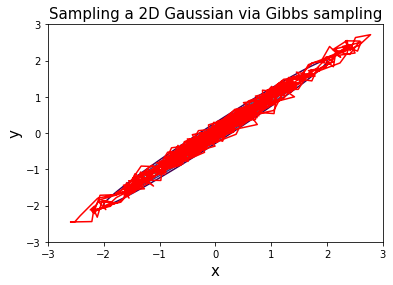

In [6]:
sampling = GibbsSampling([lambda x: cond_prob(1,x), lambda x: cond_prob(0,x)], [1.5,0])

samples = [sampling.sample() for _ in range(1000)]
plt.plot(np.array(samples)[:,0], np.array(samples)[:,1], 'r-')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Sampling a 2D Gaussian via Gibbs sampling', fontsize=15);
plt.contour(smpl_rej.X, smpl_rej.Y, smpl_rej.p2d.pdf(smpl_rej.XY));

Gibbs sampling is vastly popular as

* it has no free parameters which need to be tuned
* appears efficient as it moves on every sample, i.e. never rejects

Gibbs sampling is most efficient if all coordinates are almost independent. In the case of high dependencies the conditional distributions are sharply peaked and Gibbs sampling moves slowly across the space. The above example nicely illustrates this effect as the length scale of each move is restricted to the standard deviation $\sqrt{1 - 0.99^2} = 0.141$ of the conditional distribution while the actual distribution has a much larger extend.

**Example:** Gibbs sampling for Gaussian mixture model

Many machine learning applications require that we can model probability densities, including ones with complicated shapes and in high dimensions. Parametric models, such as Gaussian distributions, are well studied and understood, but only provide good models if its assumptions of unimodality and rather light tails are matched by the data. Mixture models provide a principled and flexible way to extent <font color='red'>extend</font> the type of densities that can be modeled. Here, the density is assumed to be composed of different (mixture) components each of which can be described by a simple parametric form. Especially Gaussian mixture models, not least due to efficient estimation algorithms, are vastly popular in machine learning. 

The Gaussian mixture model describes a density $p(\mathbf{x})$ as follows:
$$ p(\mathbf{x}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{Sigma}_k) $$
Thus, it models the density as a sum/mixture of $K$ Gaussian components. Here, $(\pi_k)_{k=1}^K$ denotes the probability of each component and $\mathbf{\mu}_k, \mathbf{\Sigma}_k$ are the component means and covariances respectively.

Introducing a latent variable $z \in \{1,\ldots,K\}$ we can also think of a datum $\mathbf{x}$ as being generated by the following process:
$$ \begin{array}{clc} z & \sim & \pi \\ \mathbf{x} & \sim & \mathcal{N}(\mathbf{\mu}_z, \mathbf{\Sigma}_z) \end{array} $$

Thus, to estimate parameters of a Gaussian mixture model from a data set $\mathcal{X} = (\mathbf{x}_n)_{n=1}^N$, we need to

* infer the hidden component assignments $(z_n)_{n=1}^K$
* infer the component means $(\mathbf{\mu}_k)_{k=1}^K$ and covariances $(\mathbf{\Sigma}_k)_{k=1}^K$

As a Bayesian, we do this by computing the corresponding posterior distributions. Unfortunately, since the assignments $(z_n)$ are unobserved, the likelihood needs to marginalize over all possible component assignments leading to an intractable sum over exponentially many terms. Thus, in practice we need to approximate the posterior, and many such algorithms have been developed for the Gaussian mixture model:

* **EM algorithm**: The *expectation-maximization* algorithm computes the maximum likelihood parameters of the mixture components
* **Variational Bayes**: Similar to the EM algorithm, but computing an approximate posterior distribution over the parameters
* **Gibbs sampling**: Sampling algorithm which explores the posterior distribution, over assignments and parameters.

Here, we will implement Gibbs sampling. Thus, we need to be able to compute conditional posterior distributions. In the Gaussian mixture model this requires that we use conjugate priors leading to the following generative model:
$$ \begin{array}{lcl} \pi & \sim & \mathcal{D}irichlet(\mathbf{\alpha}) \\
  \mathbf{\mu}_, \mathbf{\Lambda}_k & \sim & \mathcal{W}ishart-\mathcal{N}ormal(\mathbf{\mu}_0, \nu, \kappa, \mathbf{S}_0) \quad \forall k = 1,\ldots,N \\
  z_n & \sim & \pi \\
  \mathbf{x}_n & \sim & \mathcal{N}(\mathbf{\mu}_{z_n}, \mathbf{\Lambda}^{-1}_{z_n}) \quad \forall n = 1,\ldots,N 
  \end{array} $$

**Exercise:** Show that the Dirichlet distribution is the conjugate prior for the categorical variable $Z$.

The conjugate prior for a multi-variate Gaussian with unknown mean and precision matrix is the *Normal-Wishart* distribution. For the math, e.g. posterior parameters, we refer to K. Murphy, *Conjugate Bayesian analysis of the Gaussian distribution*. Here, we use these results to implement the *collapsed Gibbs sampler*, i.e. with the mixture parameters $\mathbf{\mu}_k, \mathbf{\Lambda}_k$ integrated out analytically.

Thus, we approximate the marginal posterior $p(z_1,\ldots,z_N | \mathcal{X})$ by sampling from its conditional distributions:
$$ \begin{array}{lcl} p(z_i | \mathcal{X}, \mathbf{z}_{-i}) & \propto & p(z_i | \mathbf{z}_{-i}) p(\mathcal{X} | z_i, \mathbf{z}_{-i}) \\
& = & p(z_i | \mathbf{z}_{-i}) p(\mathbf{x}_i | \mathcal{X}_{-i}, z_i, \mathbf{z}_{-i}) p(\mathcal{X}_{-i} | z_i, \mathbf{z}_{-i}) \\
& \propto & p(z_i | \mathbf{z}_{-i}) p(x_i | \mathcal{X}_{-i}, z_i, \mathbf{z}_{-i}) \end{array}$$
where $_{-i}$ denotes a vector without the $i$th component and we have used conditional independence in the model, namely that $p(\mathcal{X}_{-i} | z_i, \mathbf{z}_{-i}) = p(\mathcal{X}_{-i} | \mathbf{z}_{-i})$.

Thanks to conjugacy both terms can be computed analytically, being the predictive distributions from the Dirichlet and Normal-Wishart posteriors. For the second term note that $p(\mathbf{x}_i | \mathcal{X}_{-i}, z_i, \mathbf{z}_{-i})$ only depends on the data points that are assigned to the same component as $z_i$. In order to compute the corresponding distributions for each component, we keep track of the (unnormalized) empirical means, i.e. $\sum_{n=1, z_n = k}^K \mathbf{x}_n$, and covariance terms, i.e. $\sum_{n=1, z_n = k}^K \mathbf{x}_n \mathbf{x}_n^T$.

A step of the collapsed Gibbs sampler then works as follows:

* For $i = 1:N$
  1. Remove $\mathbf{x}_i$ from component $z_i$
  2. For $k = 1:K$
       
       Compute $p(z_i=k | \mathcal{X}, \mathbf{z}_{-i}) \propto p(z_i=k | \mathbf{z}_{-i}) p(x_i | \mathcal{X}_{-i}, z_i=k, \mathbf{z}_{-i})$
       
  3. Draw new assignment $z'_i$ from this distribution (after normalization) 
  4. and add $\mathbf{x}_i$ to component $z'_i$

In [7]:
# <api>
class GaussStatistics (object):
    """
    Stores statistics of data for Gaussian model
    """
    def __init__(self, X):
        N, D = X.shape
        # Store number of samples
        self.N = N
        # sum of samples
        self.x = np.reshape(np.sum(X, axis=0), (D,1))
        # and sum of outer squares
        self.xxT = np.dot(X.T, X)

# Computations for conjugate priors
def posterior_NormalWishart (stats, mu0, nu, kappa, S0):
    """
    Computes posterior parameters of Normal-Wishart

    see Murphy, page 18
    """
    nuN = nu + stats.N
    kappaN = kappa + stats.N
    # Note: Formula adapted to statistics
    muN = (kappa*mu0 + stats.x)/kappaN
    SN = S0 + stats.xxT + kappa*np.dot(mu0, mu0.T) - kappaN*np.dot(muN, muN.T)
    return muN, nuN, kappaN, SN

def predictive_NormalWishart (x, muN, nuN, kappaN, SN):
    """
    Predictive distribution of Normal-Wishart

    see Murphy, page 19
    """
    D, k = x.shape
    return mvt_log_pdf(x, muN, nuN-D+1, SN*(kappaN+1)/(kappaN*(nuN-D+1)))

def mvt_log_pdf (x, mu, nu, Sigma):
    """
    Compute log density of multi-variate Student t distribution
    """
    D, k = x.shape
    return np.math.lgamma((nu + D)/2.) - np.math.lgamma(nu/2.) - D/2.*np.log(nu*np.pi) \
        - 1/2.*np.linalg.slogdet(Sigma)[1] \
        - ((nu+D)/2.)*np.log(1 + 1/nu*np.dot((x - mu).T, np.linalg.solve(Sigma, x - mu)))

In [8]:
# <api>
# Finally, we can implement the collapsed Gibbs sampler
def gmm_Gibbs_step (X, z, comp_stats, alpha, mu0, nu, kappa, S0):
    """
    Run single Gibbs step, i.e. update each assignment z_i
    
    comp_stats contains GaussianStatistics for each mixture component
    """
    N, D = X.shape
    assert len(z) == N, 'each data point must be assigned to exactly one mixture component'
    K = len(comp_stats)
    assert np.min(z) >= 0 and np.max(z) < K, 'assignment and components do not match'

    for i in range(len(z)):
        # Current assignment
        zi = z[i]

        # Fetch data point and remove it from statistics
        xi = np.reshape(X[i,:], (D,1))
        Ni = comp_stats[zi].N
        comp_stats[zi].N = Ni - 1
        comp_stats[zi].x = comp_stats[zi].x - xi
        comp_stats[zi].xxT = comp_stats[zi].xxT - np.dot(xi, xi.T)
        
        # Compute conditional probabilities for zi
        log_cond_probs = np.zeros(K)
        for k in range(K):
            post_i = posterior_NormalWishart (comp_stats[k], mu0, nu, kappa, S0)
            log_pred_xi = predictive_NormalWishart(xi, *post_i)
            # Predictive cond. probability from Dirichlet
            log_pred_diri = np.log((comp_stats[k].N + alpha)/(N + K*alpha - 1)) # - 1 ???
            log_cond_probs[k] = log_pred_diri + log_pred_xi

            # if i == 0:
            #     print comp_stats[k].N, log_pred_diri, log_pred_xi

        # Normalize probs in log space
        log_cond_probs -= logsumexp(log_cond_probs)
        
        # Sample new assignment from this distribution
        zi_new = np.random.choice(K, p=np.exp(log_cond_probs))
        z[i] = zi_new
        # and add xi to its statistics
        Ni_new = comp_stats[zi_new].N
        comp_stats[zi_new].N = Ni_new + 1
        comp_stats[zi_new].x = comp_stats[zi_new].x + xi
        comp_stats[zi_new].xxT = comp_stats[zi_new].xxT + np.dot(xi, xi.T)

    # Finally, return new assignments and statistics
    return z, comp_stats

Finally, we test the whole thing on some demo data and with nice graphics $\ldots$

Note that there are different choices of how the initial assignment can be chosen:

* All in one component, i.e. $z_n = 1$ for all $n$
* At random, i.e. each data point is assigned to a random component $1, \ldots, K$
* Using some clustering algorithm, e.g. K-means

In [9]:
# <api>
def gmm_Gibbs_demo (X, K, alpha, mu0, nu, kappa, S0, iter=100):
    """
    Run Gibbs sampler on Gaussian mixture model with K components and
    the given hyperparameters

    Plot fancy stuff on each iteration
    """
    N, D = X.shape
    assert D == 2, 'cannot plot data with more than 2 dimensions'
    # Draw initial assignment at random
    z = np.random.choice(K, size=N)
    z = np.array([0 for _ in range(N)])
    # z = np.concatenate(([0 for _ in range(100)], [1 for _ in range(100)], [2 for _ in range(30)]))
    # and initialize component statistics
    comp_stats = [GaussStatistics(X[z == k,:]) for k in range(K)]

    fig = plt.figure(1)
    # Plot 1-stdev ellipse for each mixture component
    for k in range(K):
        muN, nuN, kappaN, SN = posterior_NormalWishart (comp_stats[k], mu0, nu, kappa, S0)
        plot_cov_ellipse(SN/nuN, muN, nstd=1, alpha=0.1)
        plt.scatter(muN[0], muN[1], marker='x', s=50)
    plt.scatter(X[:,0], X[:,1], c=z)

    # Plot predictive density
    def pred (x, comp_stats, post_K):
        K = len(comp_stats)
        return np.exp(logsumexp([np.log((comp_stats[k].N + alpha)/(N + alpha*K)) + predictive_NormalWishart(x, *post_K[k]) \
                                 for k in range(K)]))
    xmin, xmax, ymin, ymax = plt.axis()
    fun_contour(np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50), \
                lambda x,y: pred(np.array([[x],[y]]), comp_stats, \
                                 [posterior_NormalWishart(comp_stats[k], mu0, nu, kappa, S0) for k in range(K)]), \
                cmap='gray',
                alpha=0.2)
        
    plt.pause(0.1)
    
    for i in range(iter):
        z, comp_stats = gmm_Gibbs_step (X, z, comp_stats, alpha, mu0, nu, kappa, S0)

        if i % 10 == 0:
            print (i)
            fig.clear()
            for k in range(K):
                muN, nuN, kappaN, SN = posterior_NormalWishart (comp_stats[k], mu0, nu, kappa, S0)
                plot_cov_ellipse(SN/nuN, muN, nstd=1, alpha=0.1)
                # Plot large mark for posterior mean
                plt.scatter(muN[0], muN[1], marker='x', s=50)
            fun_contour(np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50), \
                        lambda x,y: pred(np.array([[x],[y]]), comp_stats, \
                                         [posterior_NormalWishart(comp_stats[k], mu0, nu, kappa, S0) for k in range(K)]), \
                        cmap='gray',
                        alpha=0.2)

            plt.scatter(X[:,0], X[:,1], c=z)
            fig.canvas.draw()

    return z, comp_stats

# Helper function from: https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

# Helper function to plot nice, smooth contours of a function
def fun_contour (xr, yr, f, **im_kargs):
    """
    Evaluates function over a regular grid xr x yr and plots smooth,
    colored contours on current axes
    """
    xg, yg = np.meshgrid(xr, yr)
    zg = np.reshape([f(x,y) for x,y in zip(xg.ravel(), yg.ravel())], xg.shape)
    plt.imshow(zg, interpolation='bilinear', vmin=zg.min(), vmax=zg.max(), \
               extent = [xg.min(), xg.max(), yg.min(), yg.max()], \
               origin='lower', **im_kargs)
    #plt.contour(xg, yg, zg, 42, **im_kargs)

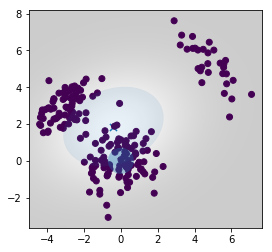

0
10
20
30
40
50
60
70
80
90


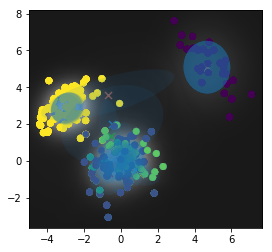

In [10]:
# Test the whole thing on some demo data
X_mix = np.concatenate((np.random.multivariate_normal(np.array([0, 0]), np.array([[1, 0], [0, 1]]), size=100), \
                        np.random.multivariate_normal(np.array([-3, 3]), np.array([[0.5, 0.2], [0.2, 0.5]]), size=70), \
                        np.random.multivariate_normal(np.array([5, 5]), np.array([[1, -0.8], [-0.8, 1]]), size=30)), \
                       axis = 0)

N, D = X_mix.shape
K = 5
gmm_Gibbs_demo(X_mix, K, 1, np.zeros((2,1)), D, 1, np.eye(D));

**Exercise**: Explore the collapsed Gibbs sampler on different data sets, e.g. with two components of varying size and separation. When does it work well and when does it fail to mix?

**Exercise**: Implement the uncollapsed Gibbs sampler, i.e. sampling from the full posterior
$$ p(z_1,\ldots,z_N, \{\mathbf{\mu}\}_{k=1}^N, \{\mathbf{\Lambda}\}_{k=1}^N | \mathcal{X}) $$
Hint: Use conjugate priors, i.e. $\mu_k \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ and $\Lambda_k \sim \mathcal{W}ishart(\nu, \mathbf{S}_0)$, and exploit conditional independencies, i.e. $$p(x_i | \mathcal{X}_{-i}, (z_n)_{n=1}^N, \{\mathbf{\mu}\}_{k=1}^N, \{\mathbf{\Lambda}\}_{k=1}^N) = p(x_i | \mathbf{\mu}_{z_i}, \mathbf{\Lambda}_{z_i}) $$

__Example__: Gibbs sampling for linear regression

Let $\mathbf{X}$ denote the design matrix, i.e. values of $D$ regressors (plus bias input) for $N$ training cases collected in a $N \times D$ matrix, and $\mathbf{t} \in \mathbb{R}^N$ denote the target outputs.

Linear regression then models the targets as
$$ p(\mathbf{t} | \mathbf{X}, \mathbf{w}, \tau) = \prod_{i=1}^N \mathcal{N}(t_i ; \mathbf{w}^T \mathbf{x}_i, \tau) $$
with weight vector $\mathbf{w}$ and observation noise precision $\tau = \frac{1}{\sigma^2}$.

With conjugate priors the conditional posterior distributions can be computed analytically:
* $\mathbf{w}$: Conjugate prior is Gaussian with mean $\mathbf{0}$ and covariance $\Sigma_0$
  
  Posterior is also Gaussian with covariance
  $$ \Sigma_N = ( \Sigma_0^{-1} + \tau \mathbf{X}^T \mathbf{X} )^{-1} $$
  and mean
  $$ \mu_N = \tau \Sigma_N \mathbf{X}^T \mathbf{t} $$
* $\tau$: Conjugate prior is Gamma with shape $\alpha_0$ and rate $\beta_0$

  Posterior is again a Gamma distribution with shape $\alpha_N = \alpha_0 + \frac{N}{2}$ and rate $\beta_N = \beta_0 + \frac{1}{2} (\mathbf{t} - \mathbf{X} \mathbf{w})^T (\mathbf{t} - \mathbf{X} \mathbf{w})$
  
The program below implements the Gibbs updates according to the above formulas

In [11]:
# <api>
def lm_Gibbs_w (sample, X, t, Sigma_0_inv):
    # Compute posterior covariance
    tau = sample[1]
    Sigma_N = np.linalg.inv( Sigma_0_inv + tau*np.dot(X.T, X) )
    # and mean
    mu_N = tau*np.dot(Sigma_N, np.dot(X.T, t))
    # Draw new weight vector for next sample
    w_new = np.random.multivariate_normal(mu_N.squeeze(), Sigma_N, size=1)
    return w_new.T

def lm_Gibbs_tau (sample, X, t, alpha_0, beta_0):
    # Compute posterior shape
    N, D = X.shape
    alpha_N = alpha_0 + 0.5*N
    # and rate
    w = sample[0]
    err = t - np.dot(X, w)
    beta_N = beta_0 + 0.5*np.dot(err.T, err).squeeze()
    # Draw new precision for next sample
    tau_new = np.random.gamma(alpha_N, 1.0/beta_N, size=1)
    return tau_new

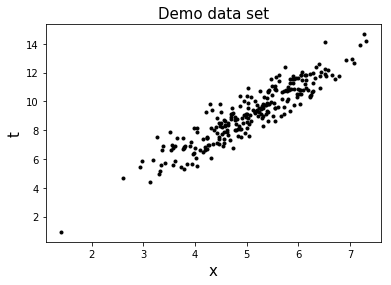

In [15]:
# Small demo data set
N = 250
x = np.hstack([np.ones((N,1)), 5+np.random.normal(size=(N,1))])
t = (np.dot(x, np.array([-1,2])) + np.random.normal(size=(N,), scale=0.8))[:,np.newaxis]
plt.plot(x[:,1], t, 'k.')
plt.title('Demo data set', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('t', fontsize=15);

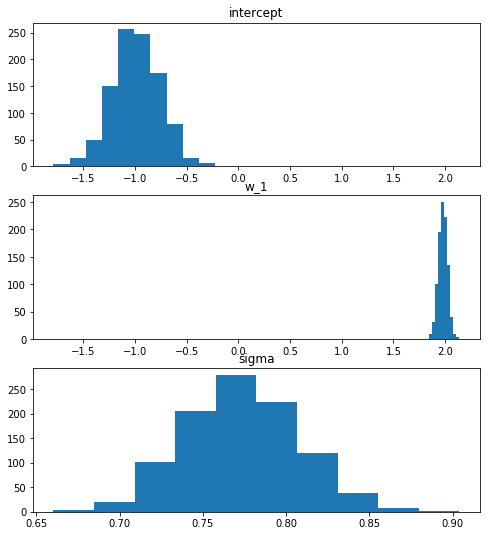

In [13]:
# Hyper parameters
N, D = x.shape
alpha_0 = beta_0 = 0.01;
Sigma_0_inv = np.linalg.inv( np.eye(D) )

# Gibbs samples
w = np.reshape(np.zeros(D), (D,1))
sampling = GibbsSampling([lambda s: lm_Gibbs_w(s, x, t, Sigma_0_inv), 
                          lambda s: lm_Gibbs_tau(s, x, t, alpha_0, beta_0)],
                         [w, 1.0])

samples = [sampling.sample() for _ in range(1000)]

# Plot histogramm of weights and precision
plt.figure(figsize=(8, 9))
ax = plt.subplot(311)
plt.hist(list(map(lambda x: float(x[0][0]), samples)))
plt.title('intercept')
plt.subplot(312, sharex=ax)
plt.hist(list(map(lambda x: float(x[0][1]), samples)))
plt.title('w_1')
plt.subplot(313)
plt.hist(list(map(lambda x: 1.0/np.sqrt(float(x[1])), samples)))
plt.title('sigma');

**Exercise**: Define a Gibbs sampler which samples each weight individually. What are the advantages/disadvantages of this approach?